In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/assignment2/'

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [ ]:
batch_size = 200
num_iters = 20000
input_dim = 28*28
num_hidden = 300
output_dim = 10

learning_rate = 0.01

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

164


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.Softmax(dim=0)
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=300, out_features=300, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=300, out_features=300, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=300, out_features=300, bias=True)
  (relu_4): Softmax(dim=0)
  (linear_5): Linear(in_features=300, out_features=300, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=300, out_features=300, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=300, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)
 
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Iteration: 500. Loss: 1.8512195348739624. Accuracy: 28.462646635110104
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 1000. Loss: 1.650388240814209. Accuracy: 42.642519036838856
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1500. Loss: 1.5356346368789673. Accuracy: 46.141181313027374
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 2000. Loss: 1.4170032739639282. Accuracy: 46.799753035604034
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2500. Loss: 1.3892790079116821. Accuracy: 48.096316114426834
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Iteration: 3000. Loss: 1.4147409200668335. Accuracy: 48.46676270837621
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Iteration: 3500. Loss: 1.2906434535980225. Accuracy: 48.77546820333402
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Iteration: 4000. Loss: 1.3119064569473267. Accuracy: 49.98

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/assignment2/model_base.pkl')

[1.8512195348739624, 1.650388240814209, 1.5356346368789673, 1.4170032739639282, 1.3892790079116821, 1.4147409200668335, 1.2906434535980225, 1.3119064569473267, 1.4828318357467651, 1.3734402656555176, 1.3938610553741455, 1.4535990953445435, 1.1985503435134888, 1.292436122894287, 1.3495168685913086, 1.241123914718628, 1.2862132787704468, 1.1762734651565552, 1.2267780303955078, 1.1797358989715576, 1.2754207849502563, 1.3155077695846558, 1.2167744636535645, 1.2776057720184326, 1.2090697288513184, 1.1806843280792236, 1.241382360458374, 1.2894212007522583, 1.2837239503860474, 1.2293157577514648, 1.1721301078796387, 1.04794180393219]


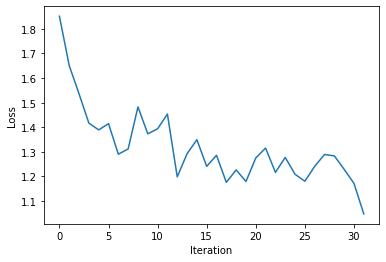

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()